<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [ ]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import xgboost as xgb
import pickle
from sklearn.metrics import confusion_matrix, adjusted_rand_score
import plotly.graph_objects as go
from itertools import cycle, islice

import scanpy as sc
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=200)

In [ ]:
#Defining class that contains functions that will perform the mapping with XGBoost and plot the results
class Tasic2018Mapping():

    # xgbclassifier will run the feature selection, training and validation, and testing
    def xgbclassifier(
        self,
        train_anndata,
        test_anndata,
        train_dict,
        test_dict,
        max_cells_per_ident = 700,
        train_frac = 0.7
        ): 

        self.train_dict = train_dict
        self.test_dict = test_dict

        self.numbertrainclasses = len(train_anndata.obs.subclass_region.values.categories)
        self.numbertestclasses = len(test_anndata.obs.Subclass.values.categories)

        #Splitting the cell barcodes into a training set and validation set based on the minimum of 70% of cells or 700 cells
        #Creating array of the labels for each cell (the cluster each cell barcode belongs too)
        training_set_train = []
        training_label_train = []

        for i in train_anndata.obs.subclass_region.values.categories.values:
            cells_in_clust = train_anndata.obs.index[train_anndata.obs.subclass_region.values == i]
            n = min(max_cells_per_ident,round(len(cells_in_clust)*train_frac))
            train_temp = np.random.choice(cells_in_clust,n,replace = False)
            if len(train_temp) < 100:
                train_temp_bootstrap = np.random.choice(train_temp, size = 100 - int(len(train_temp)))
                train_temp = np.hstack([train_temp_bootstrap, train_temp])
            training_set_train = np.hstack([training_set_train,train_temp])
            training_label_train = np.hstack([training_label_train,np.repeat(train_dict[i],len(train_temp))])

        training_set_test = []
        training_label_test = []

        for i in test_anndata.obs.Subclass.values.categories.values:
            cells_in_clust = test_anndata.obs.index[test_anndata.obs.Subclass.values == i]
            n = min(max_cells_per_ident,round(len(cells_in_clust)*train_frac))
            train_temp = np.random.choice(cells_in_clust,n,replace = False)
            if len(train_temp) < 100:
                train_temp_bootstrap = np.random.choice(train_temp, size = 100 - int(len(train_temp)))
                train_temp = np.hstack([train_temp_bootstrap, train_temp])
            training_set_test = np.hstack([training_set_test,train_temp])
            training_label_test = np.hstack([training_label_test,np.repeat(test_dict[i],len(train_temp))])

        train_index_train = []
        for i in training_set_train:
            train_index_train.append(np.where(train_anndata.obs.index.values == i)[0][0])

        train_index_test = []
        for i in training_set_test:
            train_index_test.append(np.where(test_anndata.obs.index.values == i)[0][0])

        train_matrix_train = xgb.DMatrix(data = train_anndata.X[train_index_train,:], label = training_label_train, feature_names = train_anndata.var.index.values)

        train_matrix_test = xgb.DMatrix(data = test_anndata.raw.X.A[train_index_test,:], label = training_label_test, feature_names = test_anndata.var.index.values)

        del training_set_train, training_label_train, training_set_test, training_label_test, train_index_train, train_index_test

        #Defining parameters for the XGBoost Model
        xgb_params_train = {
            'objective':'multi:softprob',
            'eval_metric':'mlogloss',
            'num_class':self.numbertrainclasses,
            'eta':0.2,
            'max_depth':6,
            'subsample': 0.6}
        nround = 200

        #Fitting the XGBoost Model to the training data
        bst_model_train = xgb.train(
            params = xgb_params_train,
            dtrain = train_matrix_train,
            num_boost_round = nround)

        xgb_params_test = {
            'objective':'multi:softprob',
            'eval_metric':'mlogloss',
            'num_class':self.numbertestclasses,
            'eta':0.2,
            'max_depth':6,
            'subsample': 0.6}
        nround = 200

        #Fitting the XGBoost Model to the testing data
        bst_model_test = xgb.train(
            params = xgb_params_test,
            dtrain = train_matrix_test,
            num_boost_round = nround)

        train_xgboost_scores = bst_model_train.get_score(importance_type="gain")
        sort_train_scores = {k: v for k, v in sorted(train_xgboost_scores.items(), key=lambda item: item[1], reverse = True)[:500]}
        top500genestrain = list(sort_train_scores.keys())

        test_xgboost_scores = bst_model_test.get_score(importance_type="gain")
        sort_test_scores = {k: v for k, v in sorted(test_xgboost_scores.items(), key=lambda item: item[1], reverse = True)[:500]}
        top500genestest = list(sort_test_scores.keys())

        common_top_genes = np.array([i for i in top500genestrain if i in top500genestest]) #These are the features that we will use for training, validating and testing

        #Saving the trasining features to save time if we need to run again
        top_genes_save = pd.DataFrame(common_top_genes, columns = ['Common_Top_Genes'])
        top_genes_save.to_csv('/content/drive/My Drive/MVC/Figure1/Tasic2018Mapping_intron_grouped_comtopgenes.csv', index = False)

        del train_matrix_train, train_matrix_test, bst_model_train, bst_model_test, train_xgboost_scores, sort_train_scores, top500genestrain, test_xgboost_scores, sort_test_scores, top500genestest

        #Train XGBoost on 70% of training data and validate on the remaining data
        common_top_genes_index_train = []
        for i in common_top_genes:
            common_top_genes_index_train.append(np.where(train_anndata.var.index.values == i)[0][0])

        training_set_train_70 = []
        validation_set_train_70 = []
        training_label_train_70 = []
        validation_label_train_70 = []

        for i in train_anndata.obs.subclass_region.values.categories.values:
            cells_in_clust = train_anndata.obs.index[train_anndata.obs.subclass_region.values == i]
            n = min(max_cells_per_ident,round(len(cells_in_clust)*train_frac))
            train_temp = np.random.choice(cells_in_clust,n,replace = False)
            validation_temp = np.setdiff1d(cells_in_clust, train_temp)
            if len(train_temp) < 100:
                train_temp_bootstrap = np.random.choice(train_temp, size = 100 - int(len(train_temp)))
                train_temp = np.hstack([train_temp_bootstrap, train_temp])
            training_set_train_70 = np.hstack([training_set_train_70,train_temp])
            validation_set_train_70 = np.hstack([validation_set_train_70,validation_temp])
            training_label_train_70 = np.hstack([training_label_train_70,np.repeat(train_dict[i],len(train_temp))])
            validation_label_train_70 = np.hstack([validation_label_train_70,np.repeat(train_dict[i],len(validation_temp))])

        train_index_train_70 = []
        for i in training_set_train_70:
            train_index_train_70.append(np.where(train_anndata.obs.index.values == i)[0][0])
        validation_index_train_70 = []
        for i in validation_set_train_70:
            validation_index_train_70.append(np.where(train_anndata.obs.index.values == i)[0][0])

        train_matrix_train_70 = xgb.DMatrix(data = train_anndata.X[:,common_top_genes_index_train][train_index_train_70,:], label = training_label_train_70)
        validation_matrix_train_70 = xgb.DMatrix(data = train_anndata.X[:,common_top_genes_index_train][validation_index_train_70,:], label = validation_label_train_70)

        del training_set_train_70, validation_set_train_70, training_label_train_70, train_index_train_70, validation_index_train_70

        bst_model_train_70 = xgb.train(
            params = xgb_params_train,
            dtrain = train_matrix_train_70,
            num_boost_round = nround)

        validation_pred_train_70 = bst_model_train_70.predict(data = validation_matrix_train_70)

        valid_predlabels_train_70 = np.zeros((validation_pred_train_70.shape[0]))
        for i in range(validation_pred_train_70.shape[0]):
            valid_predlabels_train_70[i] = np.argmax(validation_pred_train_70[i,:])
        
        del train_matrix_train_70, validation_matrix_train_70, validation_pred_train_70

        #Train XGBoost on the full training data
        training_set_train_full = []
        training_label_train_full = []

        for i in train_anndata.obs.subclass_region.values.categories.values:
            train_temp = train_anndata.obs.index[train_anndata.obs.subclass_region.values == i]
            if len(train_temp) < 100:
                train_temp_bootstrap = np.random.choice(train_temp, size = 100 - int(len(train_temp)))
                train_temp = np.hstack([train_temp_bootstrap, train_temp])
            training_set_train_full = np.hstack([training_set_train_full,train_temp])
            training_label_train_full = np.hstack([training_label_train_full,np.repeat(train_dict[i],len(train_temp))])

        train_index_full = []
        for i in training_set_train_full:
            train_index_full.append(np.where(train_anndata.obs.index.values == i)[0][0])

        full_training_data = xgb.DMatrix(data = train_anndata.X[:,common_top_genes_index_train][train_index_full,:], label = training_label_train_full)

        del common_top_genes_index_train, training_set_train_full, training_label_train_full, train_index_full

        bst_model_full_train = xgb.train(
            params = xgb_params_train,
            dtrain = full_training_data,
            num_boost_round = nround)

        #Predict the testing cluster labels
        common_top_genes_index_test = []
        for i in common_top_genes:
            common_top_genes_index_test.append(np.where(test_anndata.var.index.values == i)[0][0])

        full_testing_data = xgb.DMatrix(data = test_anndata.raw.X.A[:,common_top_genes_index_test])
        test_prediction = bst_model_full_train.predict(data = full_testing_data)

        #Save the model trained on the full training data in order to save time if we need to run again
        pickle.dump(bst_model_full_train, open('/content/drive/My Drive/MVC/Figure1/Tasic2018Mapping_intron_grouped_fullmodel.pickle.dat', 'wb'))

        del bst_model_full_train, full_testing_data

        test_predlabels = np.zeros((test_prediction.shape[0]))
        for i in range(test_prediction.shape[0]):
            if np.max(test_prediction[i,:]) > 1.2*(1/self.numbertrainclasses):
                test_predlabels[i] = np.argmax(test_prediction[i,:])
            else:
                test_predlabels[i] = self.numbertrainclasses

        test_labels = np.zeros(len(test_anndata.obs.Subclass.values))
        for i,l in enumerate(test_anndata.obs.Subclass.values):
            test_labels[i] = test_dict[l]

        return validation_label_train_70, valid_predlabels_train_70, test_labels, test_predlabels

    #plotConfusionMatrix will take the results from the xgboost classifier and plot them
    def plotConfusionMatrix(
        self,
        ytrue,
        ypred,
        type,
        save_as,
        title = '',
        xaxislabel = '',
        yaxislabel = ''
        ):

        confusionmatrix = confusion_matrix(y_true = ytrue, y_pred = ypred)
        if type == 'mapping':
          if self.numbertrainclasses in ypred:
            confusionmatrix = confusionmatrix[0:self.numbertestclasses,0:self.numbertrainclasses+1]
          else:
            confusionmatrix = confusionmatrix[0:self.numbertestclasses,0:self.numbertrainclasses]
        confmatpercent = np.zeros(confusionmatrix.shape)
        for i in range(confusionmatrix.shape[0]):
          if np.sum(confusionmatrix[i,:]) != 0:
            confmatpercent[i,:] = confusionmatrix[i,:]/np.sum(confusionmatrix[i,:])
          else:
            confmatpercent[i,:] = confusionmatrix[i,:]
        diagcm = confmatpercent
        xticks = np.linspace(0, confmatpercent.shape[1]-1, confmatpercent.shape[1], dtype = int)
        xticksactual = []
        for i in xticks:
          if i != self.numbertrainclasses:
            xticksactual.append(list(self.train_dict.keys())[i])
          else:
            xticksactual.append('Unassigned')
        dot_max = np.max(diagcm.flatten())
        dot_min = 0
        if dot_min != 0 or dot_max != 1:
            frac = np.clip(diagcm, dot_min, dot_max)
            old_range = dot_max - dot_min
            frac = (frac - dot_min) / old_range
        else:
            frac = diagcm
        xvalues = []
        yvalues = []
        sizes = []
        for i in range(diagcm.shape[0]):
            for j in range(diagcm.shape[1]):
                xvalues.append(j)
                yvalues.append(i)
                sizes.append((frac[i,j]*35)**1.5)
        size_legend_width = 0.5
        height = diagcm.shape[0] * 0.3 + 1
        height = max([1.5, height])
        heatmap_width = diagcm.shape[1] * 0.35
        width = (
            heatmap_width
            + size_legend_width
            )
        fig = plt.figure(figsize=(width, height))
        axs = gridspec.GridSpec(
            nrows=2,
            ncols=2,
            wspace=0.02,
            hspace=0.04,
            width_ratios=[
                        heatmap_width,
                        size_legend_width
                        ],
            height_ratios = [0.5, 10]
            )
        dot_ax = fig.add_subplot(axs[1, 0])
        dot_ax.scatter(xvalues,yvalues, s = sizes, c = 'blue', norm=None, edgecolor='none')
        y_ticks = range(diagcm.shape[0])
        dot_ax.set_yticks(y_ticks)
        if type == 'validation':
          dot_ax.set_yticklabels(list(self.train_dict.keys()))
        elif type == 'mapping':
          dot_ax.set_yticklabels(list(self.test_dict.keys()))
        x_ticks = range(diagcm.shape[1])
        dot_ax.set_xticks(x_ticks)
        dot_ax.set_xticklabels(xticksactual, rotation=90)
        dot_ax.tick_params(axis='both', labelsize='small')
        dot_ax.grid(True, linewidth = 0.2)
        dot_ax.set_axisbelow(True)
        dot_ax.set_xlim(-0.5, diagcm.shape[1] + 0.5)
        ymin, ymax = dot_ax.get_ylim()
        dot_ax.set_ylim(ymax + 0.5, ymin - 0.5)
        dot_ax.set_xlim(-1, diagcm.shape[1])
        dot_ax.set_xlabel(xaxislabel)
        dot_ax.set_ylabel(yaxislabel)
        dot_ax.set_title(title)
        size_legend_height = min(1.75, height)
        wspace = 10.5 / width
        axs3 = gridspec.GridSpecFromSubplotSpec(
            2,
            1,
            subplot_spec=axs[1, 1],
            wspace=wspace,
            height_ratios=[
                        size_legend_height / height,
                        (height - size_legend_height) / height
                        ]
            )
        diff = dot_max - dot_min
        if 0.3 < diff <= 0.6:
            step = 0.1
        elif diff <= 0.3:
            step = 0.05
        else:
            step = 0.2
        fracs_legends = np.arange(dot_max, dot_min, step * -1)[::-1]
        if dot_min != 0 or dot_max != 1:
            fracs_values = (fracs_legends - dot_min) / old_range
        else:
            fracs_values = fracs_legends
        size = (fracs_values * 35) ** 1.5
        size_legend = fig.add_subplot(axs3[0])
        size_legend.scatter(np.repeat(0, len(size)), range(len(size)), s=size, c = 'blue')
        size_legend.set_yticks(range(len(size)))
        labels = ["{:.0%}".format(x) for x in fracs_legends]
        if dot_max < 1:
            labels[-1] = ">" + labels[-1]
        size_legend.set_yticklabels(labels)
        size_legend.set_yticklabels(["{:.0%}".format(x) for x in fracs_legends])
        size_legend.tick_params(axis='y', left=False, labelleft=False, labelright=True)
        size_legend.tick_params(axis='x', bottom=False, labelbottom=False)
        size_legend.spines['right'].set_visible(False)
        size_legend.spines['top'].set_visible(False)
        size_legend.spines['left'].set_visible(False)
        size_legend.spines['bottom'].set_visible(False)
        size_legend.grid(False)
        ymin, ymax = size_legend.get_ylim()
        size_legend.set_ylim(ymin, ymax + 0.5)
        fig.savefig(save_as, bbox_inches = 'tight')

        return diagcm, xticks, axs

In [ ]:
def calculateNCE(labels_true,labels_pred):
    X = labels_true
    Y = labels_pred
    contTable = confusion_matrix(X,Y)[0:len(np.unique(X)), 0:len(np.unique(Y))]
    a = np.sum(contTable, axis = 1)
    b = np.sum(contTable, axis = 0)
    N = np.sum(contTable)
    pij = contTable/N
    pi = a/N
    pj = b/N
    Hyx = np.zeros(contTable.shape)
    for i in range(contTable.shape[0]):
        for j in range(contTable.shape[1]):
          if pij[i,j] == 0:
            Hyx[i,j] = 0
          else:
            Hyx[i,j] = pij[i,j]*np.log10(pij[i,j]/pi[i])
    CE = -np.sum(Hyx)
    Hyi = np.zeros(contTable.shape[1])
    for j in range(contTable.shape[1]):
      if pj[j] == 0:
       Hyi[j] = 0
      else:
        Hyi[j] = pj[j]*np.log10(pj[j])
    Hy = -np.sum(Hyi)
    NCE = CE/Hy
    return NCE

In [ ]:
train_adata = sc.read_h5ad('Tasic2018intron_grouped.h5ad')
test_adata = sc.read_h5ad('gluta_gaba_glia_3000_combined.h5ad')

In [ ]:
#Assigning integer values to the clusters in the Tasic and V1 data in order to be able to use XGBoost
train_dict = {'Astro_VISp':0, 'Oligo_VISp':1, 'Macrophage_VISp':2, 'Endo_VISp':3, 'VLMC_VISp':4, 'SMC_VISp':5, 'Peri_VISp':6, 'Astro_ALM':7, 'Oligo_ALM':8, 'Macrophage_ALM':9, 'Endo_ALM':10, 'VLMC_ALM':11, 'SMC_ALM':12, 'Peri_ALM':13, 'Meis2_VISp':14, 'Lamp5_VISp':15, 'Vip_VISp':16, 'Pvalb_VISp':17, 'Sst_VISp':18, 'Serpinf1_VISp':19, 'Sncg_VISp':20, 'CR_VISp':21, 'Meis2_ALM':22, 'Lamp5_ALM':23, 'Vip_ALM':24, 'Pvalb_ALM':25, 'Sst_ALM':26, 'Serpinf1_ALM':27, 'Sncg_ALM':28, 'CR_ALM':29, 'L2/3 IT_VISp':30, 'L4_VISp':31, 'L5 IT_VISp':32, 'NP_VISp':33, 'L5 PT_VISp':34, 'L6 IT_VISp':35, 'L6 CT_VISp':36, 'L6b_VISp':37, 'L2/3 IT_ALM':38, 'L4_ALM':39, 'L5 IT_ALM':40, 'NP_ALM':41, 'L5 PT_ALM':42, 'L6 IT_ALM':43, 'L6 CT_ALM':44, 'L6b_ALM':45}
test_dict = {'Astrocytes':0, 'Oligodendrocytes':1, 'OPCs':2, 'Microglia':3, 'Endothelial':4, 'VLMCs':5, 'Meis2':6, 'Lamp5':7, 'Vip':8, 'Pvalb':9, 'Sst':10, 'Stac':11, 'Frem1':12, 'L2/3':13, 'L4':14, 'L5IT':15, 'L5NP':16, 'L5PT':17, 'L6IT':18, 'L6CT':19, 'L6b':20}

In [ ]:
tm = Tasic2018Mapping()

In [ ]:
validation_label_train_70, valid_predlabels_train_70, test_labels, test_predlabels = tm.xgbclassifier(
    train_anndata = train_adata,
    test_anndata = test_adata,
    train_dict = train_dict,
    test_dict = test_dict
    )

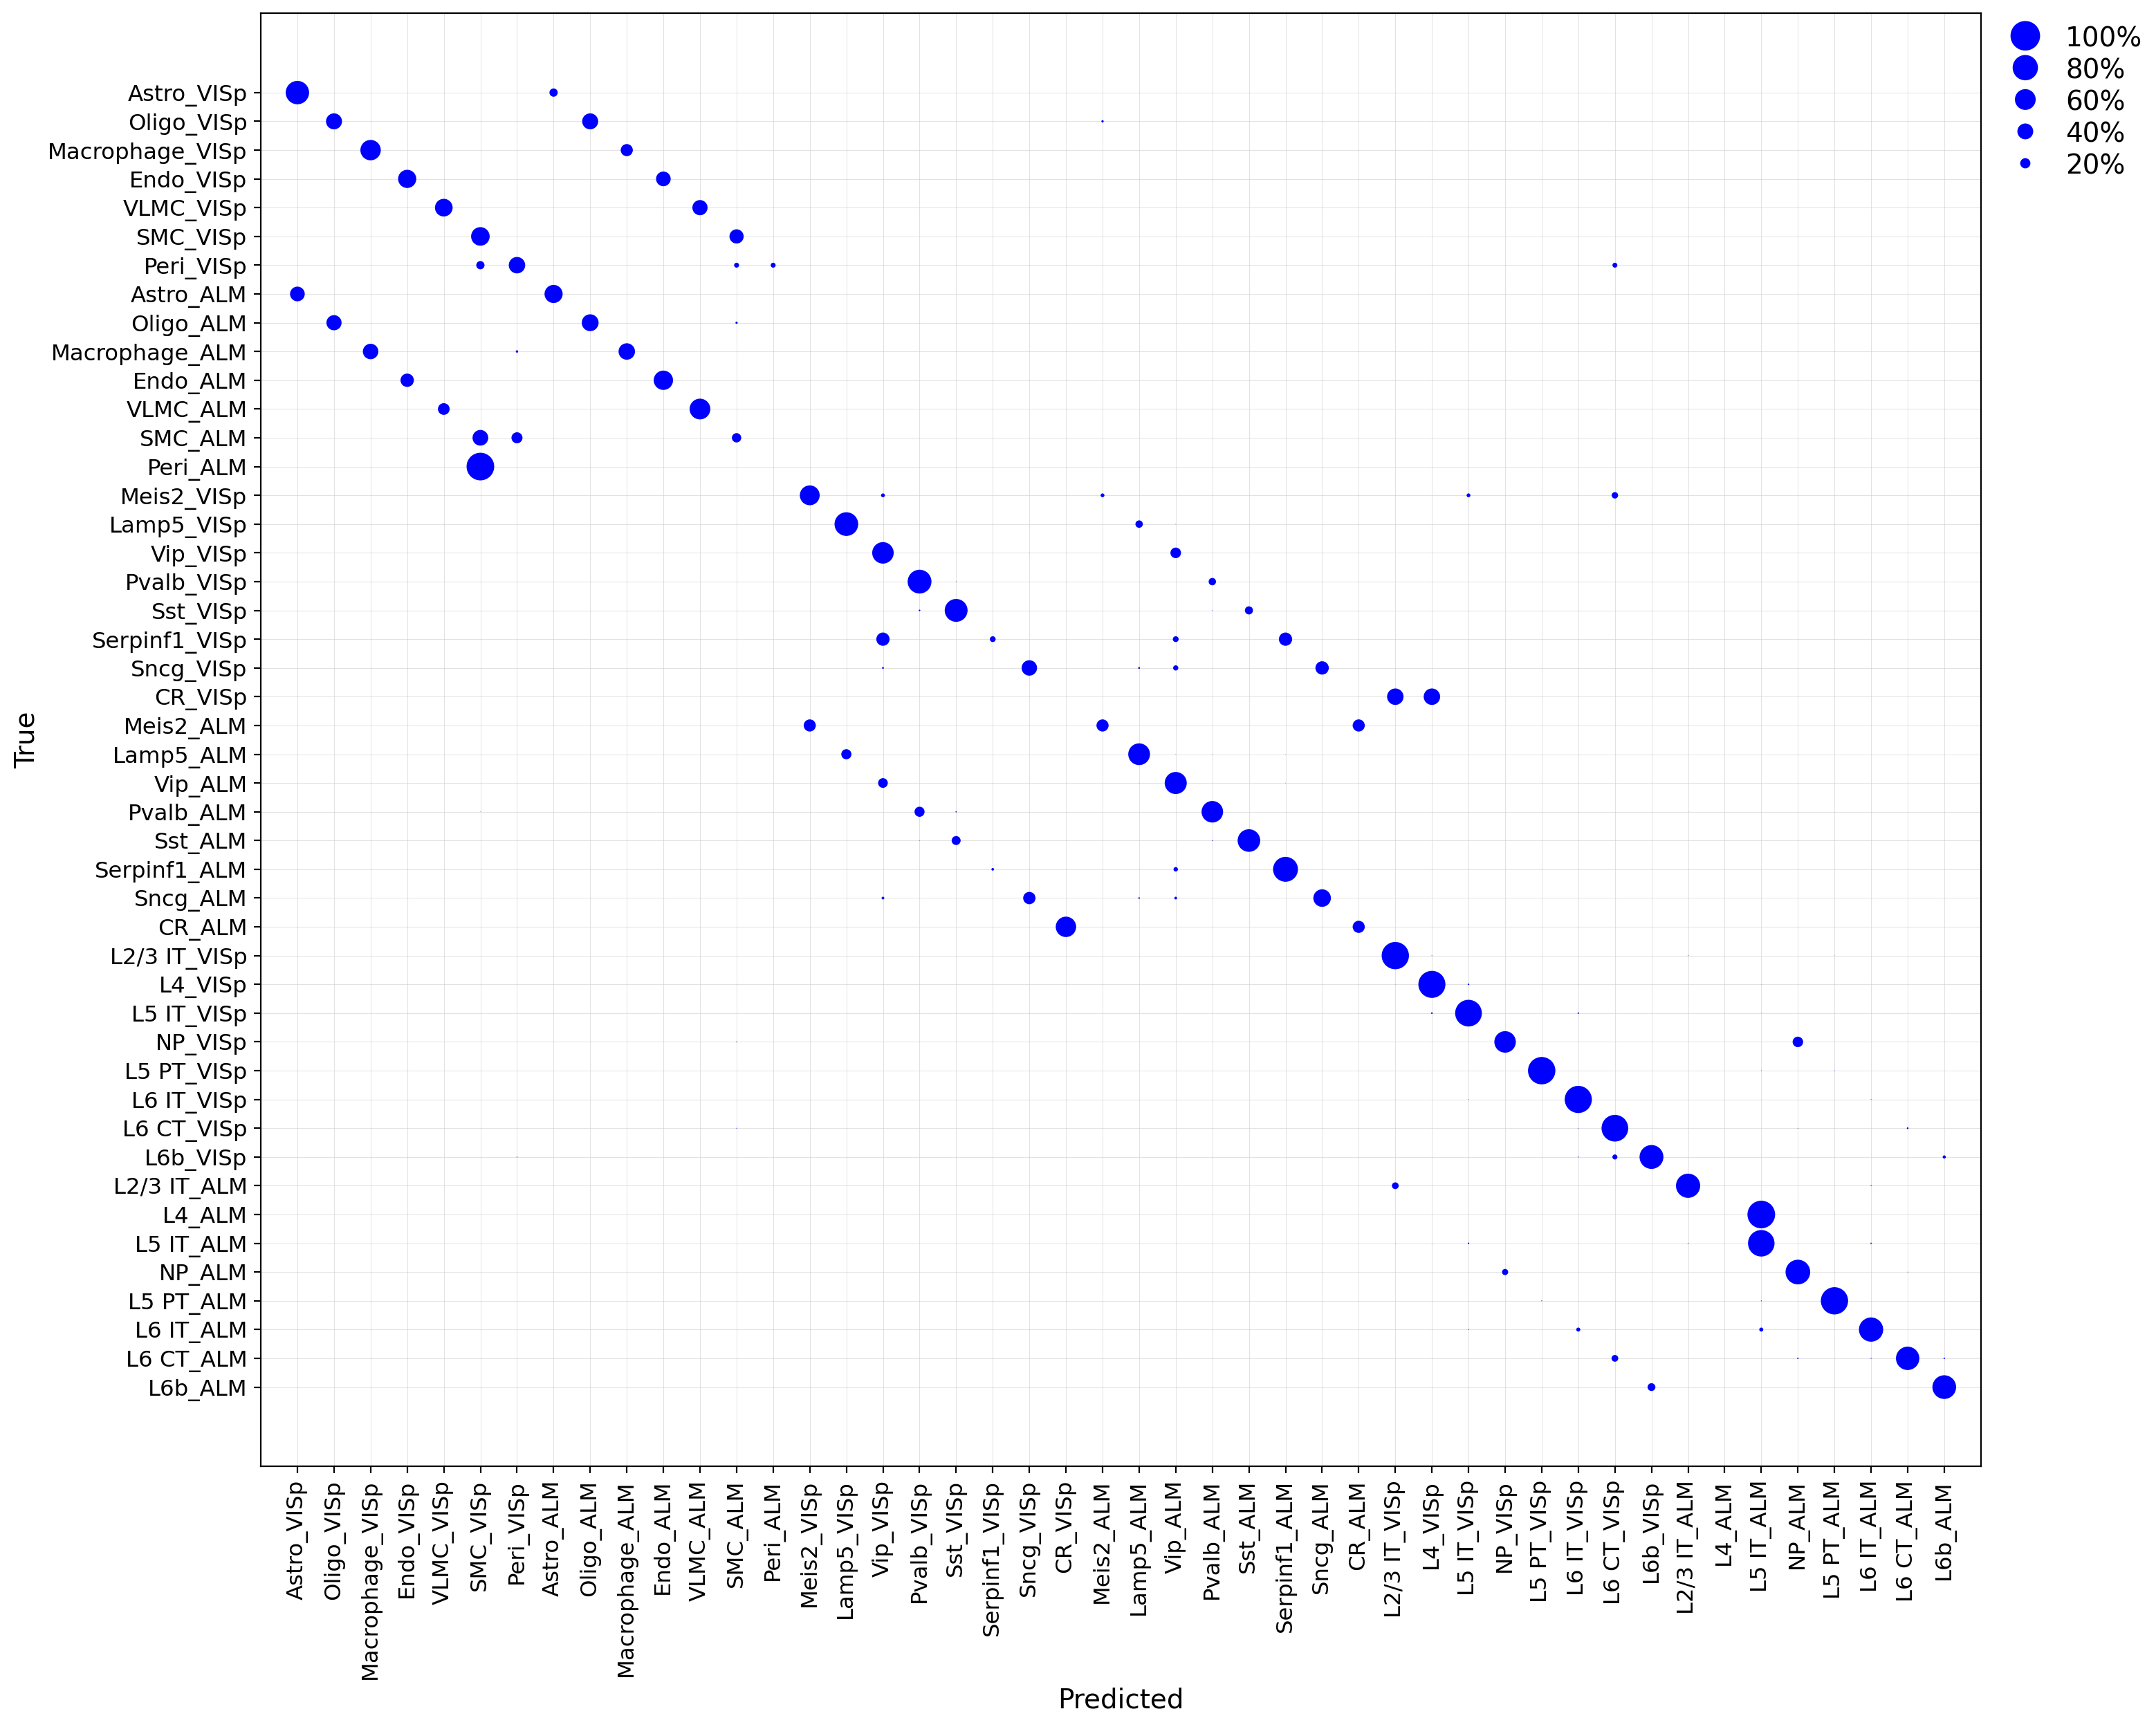

In [ ]:
validationconfmat, validationxticks, validationplot = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70,
    ypred = valid_predlabels_train_70,
    type = 'validation',
    save_as = 'Tasic2018MappingValidation_intron_grouped_0221.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

In [ ]:
mappingconfmat, mappingxticks, mappingplot = tm.plotConfusionMatrix(
    ytrue = test_labels,
    ypred = test_predlabels,
    type = 'mapping',
    save_as = 'Tasic2018MappingTesting_intron_grouped_0221.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labels, labels_pred = test_predlabels), calculateNCE(labels_true = test_labels, labels_pred = test_predlabels)),
    xaxislabel = '',
    yaxislabel = ''
    )

In [ ]:
np.save('validation_label_train_70_0221', validation_label_train_70)
np.save('valid_predlabels_train_70_0221', valid_predlabels_train_70)
np.save('test_labels_0221', test_labels)
np.save('test_predlabels_0221', test_predlabels)
np.save('mappingconfmat_0221', mappingconfmat)